<a href="https://colab.research.google.com/github/Trading-com-Dados/desenvolvimento_interno/blob/main/20220502_Quantstats_aplicada_ao_backtesting_(Backtrader_lib).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://tradingcomdados.com/images/logotipo/logotipo-trading-com-dados.svg" width="300" align="left"/>

---
# **Quantstats aplicada ao backtesting (Backtrader lib)**
---

# **1) Bibliotecas utilizadas**

In [14]:
!pip install yfinance
!pip install ta
!pip install backtrader
!pip install quantstats

In [15]:
import numpy as np
import pandas as pd
import datetime
import pytz

import yfinance as yf

import ta
import backtrader as bt
import quantstats

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

# **2. Organizar o dataset**

## **2.1. Yahoo Finance - yfinance**

In [16]:
## Importar os dados de cotações do Yahoo Finance

OHLC_BTC = yf.download('BTC-USD', period='max', interval = '1d')
OHLC_BTC

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-04-30,38605.859375,38771.210938,37697.941406,37714.875000,37714.875000,23895713731
2022-05-01,37713.265625,38627.859375,37585.789062,38469.093750,38469.093750,27002760110
2022-05-02,38472.187500,39074.972656,38156.562500,38529.328125,38529.328125,32922642426


## **2.2. Graficos**

In [ ]:
cotacoes_BTC_yf_fig = OHLC_BTC

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name='Bitcoin_USD', x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],
                                                    low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_traces(line_width=1)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=1000,height=400,
                  font=dict(family="Arial",size=20,color="black"),
                  #xaxis=dict(range=['2021-10-18', '2022-04-21'])
                  )

fig.show()

In [ ]:
cotacoes_BTC_yf_fig = OHLC_BTC[(OHLC_BTC.index > '2021-01-01')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name='Bitcoin_USD', x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],
                                                    low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_traces(line_width=1)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=1000,height=400,
                  font=dict(family="Arial",size=20,color="black"),
                  #xaxis=dict(range=['2021-10-18', '2022-04-21'])
                  )

fig.show()

# **3. Criar o Data Feeds Backtrader e Código Estratégia**

In [17]:
data = bt.feeds.PandasData(dataname=OHLC_BTC, name='Bitcoin_USD')

**Cruzamento de Médias**

In [18]:
# Create a Stratey
class Cruzamento_Medias(bt.Strategy):
    params = {'short':9,'long':20}

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        sma_short = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.short)
        sma_long = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.long)
        self.crossover = bt.indicators.CrossOver(sma_short,sma_long)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.crossover > 0:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                #self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.crossover < 0:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                #self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

# **4. Avaliar resultados da estratégia calculados pela Backtrader**

In [19]:
cerebro = bt.Cerebro()
cerebro.addstrategy(Cruzamento_Medias)

cerebro.adddata(data)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

cerebro.broker.setcash(200000)
cerebro.addsizer(bt.sizers.SizerFix, stake=1)

#MARGIN = FALSE: *commission* representa uma porcentagem do volume financeiro de negociação (price * size) (ex., emolumentos de ações e taxas de liquidação)
#MARGIN = qq valor ou None: *commission* é fixa por contrato (ex. corretagem). Lembrar q é compra/venda em cada operação fechada 
#MULT (default 1)= Fator de multiplicação aos lucros e perdas envolvendo mercados futuros (alavancagem)

cerebro.broker.setcommission(margin=None,commission=0,mult=1)

print('Valor inicial da carteira: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()
strat = results[0]

print('Valor final da carteira: %.2f' % cerebro.broker.getvalue())

Valor inicial da carteira: 200000.00
2014-10-16, BUY EXECUTED, Price: 394.52, Cost: 394.52, Comm 0.00
2014-10-27, SELL EXECUTED, Price: 354.78, Cost: 394.52, Comm 0.00
2014-10-27, OPERATION PROFIT, GROSS -39.74, NET -39.74
2014-11-12, BUY EXECUTED, Price: 367.98, Cost: 367.98, Comm 0.00
2014-11-25, SELL EXECUTED, Price: 376.89, Cost: 367.98, Comm 0.00
2014-11-25, OPERATION PROFIT, GROSS 8.90, NET 8.90
2014-12-04, BUY EXECUTED, Price: 375.72, Cost: 375.72, Comm 0.00
2014-12-11, SELL EXECUTED, Price: 344.34, Cost: 375.72, Comm 0.00
2014-12-11, OPERATION PROFIT, GROSS -31.38, NET -31.38
2015-01-28, BUY EXECUTED, Price: 263.35, Cost: 263.35, Comm 0.00
2015-02-06, SELL EXECUTED, Price: 216.92, Cost: 263.35, Comm 0.00
2015-02-06, OPERATION PROFIT, GROSS -46.43, NET -46.43
2015-02-17, BUY EXECUTED, Price: 233.42, Cost: 233.42, Comm 0.00
2015-03-21, SELL EXECUTED, Price: 261.64, Cost: 233.42, Comm 0.00
2015-03-21, OPERATION PROFIT, GROSS 28.22, NET 28.22
2015-04-10, BUY EXECUTED, Price: 243.69

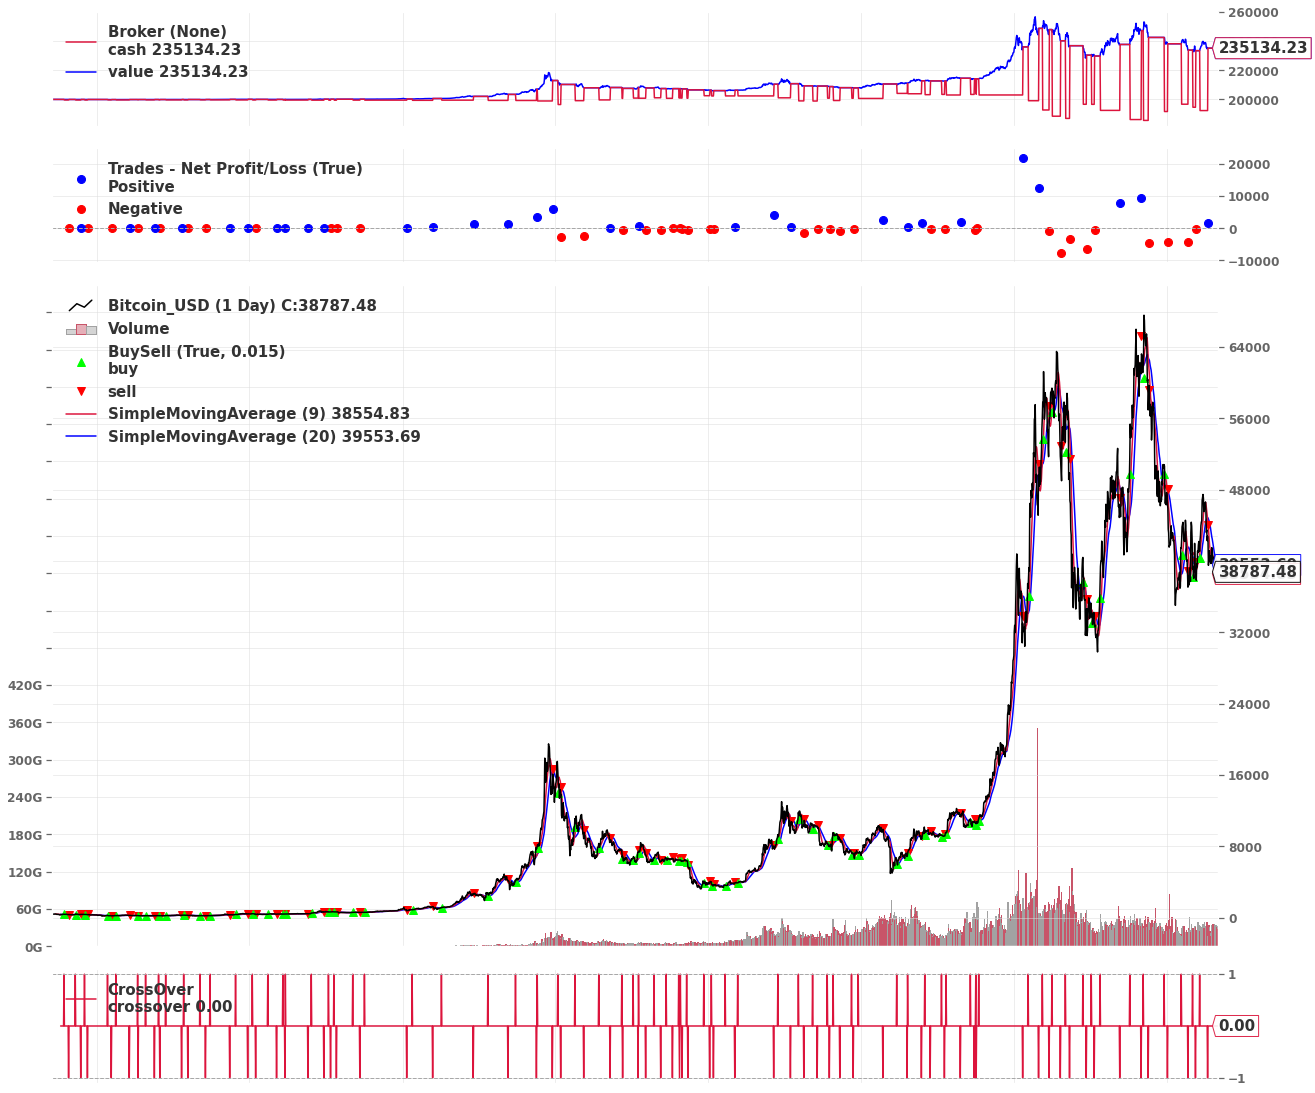

[[<Figure size 1296x1152 with 5 Axes>]]

In [20]:
plt.rcParams['figure.figsize'] = [18, 16]
plt.rcParams.update({'font.size': 15,'font.weight' : 'bold'})

cerebro.plot(iplot=False,plotdist=0.2,subtxtsize=15,fmt_x_data='%Y-%m')

In [ ]:
# AINDA PRECISO ENTENDER MELHOR ESSE OUTPUT (NAO URGENTE)

#cerebro.addwriter(bt.WriterFile, csv=True, out='Backtest_5min.csv')

# **5. Explorar as métricas do backtesting usando a Quantstats**

In [ ]:
portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

In [ ]:
quantstats.reports.html(returns, output='stats_WINFUT_1day.html', title='CrossoverMM - WINFUT 1day')